In [0]:
!pip install pandas-summary kaggle
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
# from fastai.structured import *

from pandas_summary import DataFrameSummary
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [0]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json


In [0]:
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 79.4MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
 79% 41.0M/52.2M [00:01<00:00, 15.6MB/s]
100% 52.2M/52.2M [00:01<00:00, 31.8MB/s]
 84% 49.0M/58.3M [00:01<00:00, 26.5MB/s]
100% 58.3M/58.3M [00:01<00:00, 43.1MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 106MB/s]


In [0]:
!unzip test_identity.csv.zip 
!unzip test_transaction.csv.zip
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      


In [0]:
df_test_identity = pd.read_csv('test_identity.csv', low_memory=False)
df_test_transaction = pd.read_csv('test_transaction.csv', low_memory=False)
df_train_identity = pd.read_csv('train_identity.csv', low_memory=False)
df_train_transaction = pd.read_csv('train_transaction.csv', low_memory=False)

In [0]:
df_train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have a mix of data types. Some are continous (TransactionAmt), some categorical (ProductCD) that are both Boolean (M1-M9) and character (card1-6)as well as numerica data (TransactionAmt).

Percentage of data belonging to minority class (isFraud == 1): 3.5 %


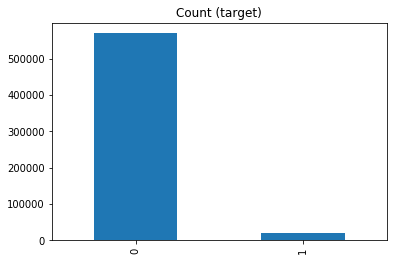

In [0]:
df_train_transaction.isFraud.value_counts().plot(kind='bar', title='Count (target)')
print('Percentage of data belonging to minority class (isFraud == 1):', round(sum(df_train_transaction.isFraud)/len(df_train_transaction)*100, 2), '%')

Further, we have a severely imbalanced dataset. Let under-sample to get equal counts of training examples of the two classes. 

In [0]:
# Class count
count_class_0, count_class_1 = df_train_transaction.isFraud.value_counts()

# Divide by class
df_class_0 = df_train_transaction[df_train_transaction['isFraud'] == 0]
df_class_1 = df_train_transaction[df_train_transaction['isFraud'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

# Randomly shuffle new dataframe
df_under_sample = df_under_sample.sample(frac=1)

In [0]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

df, y, nas = proc_df(df_under_sample, 'isFraud')

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def auc(y_true, y_scores):
  return metrics.roc_auc_score(y_true, y_scores)

def print_score(m):
    res = [auc(y_train, m.predict(X_train)), auc(y_valid, m.predict(X_valid)),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
# Split data into train/test/valid
n_valid = 8200  # 20% of training data
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((33126, 754), (33126,), (8200, 754))

In [0]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 31.3 s, sys: 406 ms, total: 31.7 s
Wall time: 9.16 s
[1.0, 0.8494127337314274, 1.0, 0.8490243902439024]


# Baseline model

In [0]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.6860722430702424, 0.688797820727215, 0.686983034474431, 0.6851219512195122]


Not a terrible baseline model, but our performance is pretty poor - 70% is not much better than 50%. Lets increase the complexity of our approach and use an ensemble of trees. 

In [0]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9970337501712546, 0.8406239268599512, 0.9970415987441889, 0.84]


In [0]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9996059173032619, 0.8467865288913772, 0.9996075590170863, 0.8463414634146341]


In [0]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9999696859464047, 0.8497766381067238, 0.9999698122320836, 0.849390243902439]


Let's see how these trees have performed as an ensemble.

In [0]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 0.225, 0)

So 94% of the trees voted corrected. What does it look like if we keep adding trees to the ensemble?

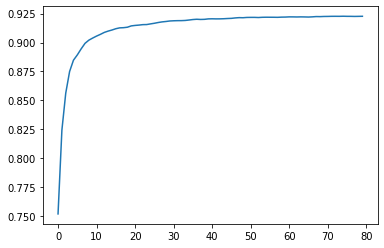

In [0]:
plt.plot([auc(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

Doesn't look like adding trees will yield better classification accuracy. Since our classification accuracy is significantly higher than our training score, we are overfitting. 

In [0]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9999696859464047, 0.8496649169940397, 0.9999698122320836, 0.8492682926829268, 0.8387067560224597]


# Reduce overfitting
Lets try sub-sample the data and see if we can generalize better. This way each tree subsamples from the overall dataset. 

In [0]:
from sklearn.ensemble import forest

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
    
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
    
set_rf_samples(10000)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9995761062967319, 0.849027437217644, 0.9995773712491698, 0.8485365853658536, 0.8298013644871098]


That didn't work too well. Let's look at growing our trees less deeply - making them simpler.

In [0]:
reset_rf_samples()


def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [0]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

67

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8905531326184292, 0.8302950050278963, 0.8907202801424863, 0.8297560975609756, 0.8223751735796655]


In [0]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

39

In [0]:
m = RandomForestClassifier(n_estimators=40, max_depth = 40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9930888988273492, 0.8507894770196366, 0.9931171889150516, 0.8503658536585366, 0.8325484513675059]


In [0]:
m = RandomForestClassifier(n_estimators=40, max_depth = 35, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9878768937972285, 0.846526133903838, 0.9879248928334239, 0.8460975609756097, 0.8310994385075168]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9185024603813254, 0.8381062000962914, 0.91867415323311, 0.8375609756097561, 0.8278995351083741]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9732048809213233, 0.8600037762033613, 0.9732536376260339, 0.8597560975609756, 0.8478234619332247]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9730796003304187, 0.8586795463010077, 0.9731328865543681, 0.8582926829268293, 0.8447141218378313]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9200745152682221, 0.8361133691701736, 0.9202439171647648, 0.8356097560975609, 0.8263901467125521]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.8583945694713246, 0.8099072854602068, 0.8586608706152267, 0.8091463414634147, 0.8042021372939685]


In [0]:
m = RandomForestClassifier(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9759817007225154, 0.8636173219553736, 0.9760309122743465, 0.8632926829268293, 0.8517780595302783]


In [0]:
# scored 87.5 on validation set
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9748087590030114, 0.8607266162653205, 0.9748535893256053, 0.8603658536585366, 0.8463744490732356]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.7, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9743563119108772, 0.8600899993150946, 0.9744007728068587, 0.8596341463414634, 0.8439292398720039]


In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.946174795119866, 0.8560163886987863, 0.9462657731087364, 0.855609756097561, 0.8437783010324217]


In [0]:
# set_rf_samples(10000)
reset_rf_samples()

In [0]:
# scored 87.5 on validation set
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.947536412296325, 0.8558430796491499, 0.9476242226649761, 0.8554878048780488, 0.8433254845136751]


# Feature importance
To reduce overfitting further and possibly increase the classification accuracy, let's determine the most important features. Features that contribute little will removed from the training data and thus our trees will not fit to this data.

In [0]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [0]:
fi = rf_feat_importance(m, df); fi[:25]

,cols,imp
311,V258,0.067081
29,C14,0.050530
370,V317,0.049821
15,R_emaildomain,0.039916
2,TransactionAmt,0.037119
28,C13,0.028991
16,C1,0.028201
4,card1,0.027981
318,V265,0.027662
310,V257,0.027421


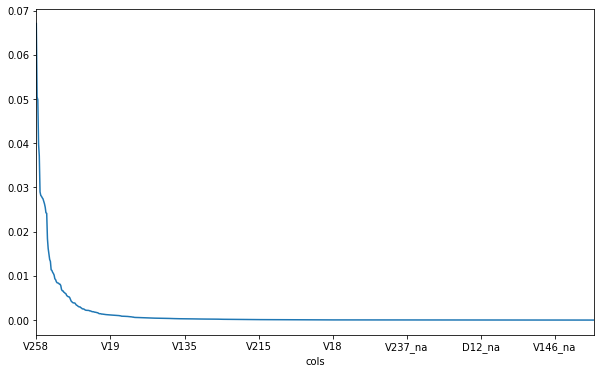

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
# plot_fi(fi[:30]);

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

46

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
# scored 87.5 on validation set w/full dataset
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9711202538821674, 0.8567984364875739, 0.9711706816397996, 0.8564634146341463, 0.8441707420153354]


Hmmm, this didn't improve our classification accuracy at all. We need to look at another approach. Let's try include the data from the identity table. 


In [0]:
df_full = df_train_transaction.merge(df_train_identity, how='left', on='TransactionID')
len(df_full)

590540

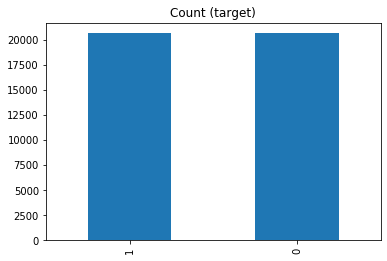

In [0]:
# Class count
count_class_0, count_class_1 = df_full.isFraud.value_counts()

# Divide by class
df_class_0 = df_full[df_full['isFraud'] == 0]
df_class_1 = df_full[df_full['isFraud'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

# Randomly shuffle new dataframe
df_under_sample = df_under_sample.sample(frac=1)

df_under_sample.isFraud.value_counts().plot(kind='bar', title='Count (target)')

In [0]:
df, y, nas = proc_df(df_full, 'isFraud')

# Split data into train/test/valid
n_valid = 8200  # 20% of training data
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((582340, 817), (582340,), (8200, 817))

In [51]:
# scored 87.5 on validation set w/full dataset
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.808595633191755, 0.712670258943272, 0.9863739396229008, 0.9724390243902439, 0.9811810969536697]


In [52]:
df, y, nas = proc_df(df_under_sample, 'isFraud')

# Split data into train/test/valid
n_valid = 8200  # 20% of training data
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((33126, 817), (33126,), (8200, 817))

In [53]:
# scored 87.5 on validation set w/full dataset
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9513193437820169, 0.8582852834139659, 0.9513373181186983, 0.8581707317073171, 0.847914025236974]


In [54]:
X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V323_na,V324_na,V325_na,V326_na,V327_na,V328_na,V329_na,V330_na,V331_na,V332_na,V333_na,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,id_13_na,id_14_na,id_17_na,id_18_na,id_19_na,id_20_na,id_21_na,id_22_na,id_24_na,id_25_na,id_26_na,id_32_na
544942,3531942,14391012,117.000,5,10960,567.0,150.0,3,117.0,3,494.0,87.0,9.0,43.0,52,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,56.0,3.0,0.0,2.0,0.0,0.0,4.958333,0.666666,0.0,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
567101,3554101,15030236,14.386,1,15315,202.0,185.0,3,137.0,2,299.0,87.0,9.0,19.0,0,0,4.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,56.0,3.0,5.0,2.0,0.0,0.0,46.958332,0.958333,0.0,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,True,False,False,True,True,True,True,True,True
395085,3382085,9927748,117.000,5,5051,478.0,150.0,4,195.0,2,441.0,87.0,9.0,43.0,17,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,56.0,3.0,0.0,2.0,0.0,0.0,4.958333,0.666666,0.0,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
195421,3182421,4398111,34.280,1,9917,142.0,185.0,4,138.0,3,299.0,87.0,9.0,43.0,20,18,1.0,7.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,3.0,3.0,3.0,3.0,1.0,23.0,23.0,0.0,0.0,0.0,0.0,0.0,0.875000,0.875000,0.0,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,True,True,True,True,True
398407,3385407,10032472,54.378,1,4329,238.0,185.0,4,102.0,2,299.0,87.0,9.0,43.0,17,15,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,56.0,3.0,0.0,2.0,0.0,0.0,4.958333,0.666666,0.0,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,False,True,True,True,True,False,False,True,False,True,False,False,True,True,True,True,True,True


In [55]:
fi = rf_feat_importance(m, df); fi[:25]

,cols,imp
311,V258,0.081478
15,R_emaildomain,0.062589
123,V70,0.045080
29,C14,0.042638
370,V317,0.040573
2,TransactionAmt,0.034171
16,C1,0.030825
28,C13,0.029285
4,card1,0.025523
347,V294,0.023369


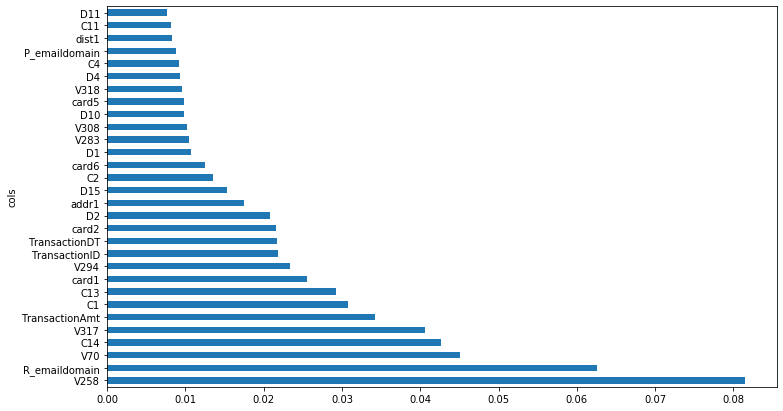

In [56]:
plot_fi(fi[:30]);

In [57]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

21

In [0]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [59]:
# scored 87.5 on validation set w/full dataset
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9688946537129378, 0.8594958885529401, 0.9689065990460666, 0.859390243902439, 0.851476181851114]


# XGBoost classifier

In [0]:
from xgboost import XGBClassifier

In [61]:
model = XGBClassifier(n_estimators=200)
model.fit(X_train,y_train)
print_score(model)

[0.8222775805428462, 0.8206486999379825, 0.8223147980438327, 0.8204878048780487]


# Cross validation
 This should really be performed since we are subsampling - also classification accuracy varies from different subsamples - 87.5 previously now only 85.2.

# END
Looks like a boosting method should be used for highly imbalanced 